In [1]:
!pip install datasets
!pip install jiwer

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 73.7 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.4 MB/s eta 0:00:00


In [4]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from jiwer import wer, cer
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchaudio.transforms as T
from torch.nn.utils.rnn import pad_sequence

In [21]:
# 경로 설정
# 샘플 데이터 경로
# audio_dir = "/content/drive/MyDrive/mini_dataset/audio"
# label_dir = "/content/drive/MyDrive/mini_dataset/label"

#경로 설정
audio_dir = "/content/drive/MyDrive/public/dataset/audio"
label_dir = "/content/drive/MyDrive/public/dataset/label"

In [5]:
# 1. Dataset 클래스 정의
class AudioDataset(Dataset):
    def __init__(self, audio_dir, label_dir, processor, target_sample_rate=16000):
        self.audio_dir = audio_dir
        self.label_dir = label_dir
        self.processor = processor
        self.target_sample_rate = target_sample_rate
        self.audio_files = [f for f in os.listdir(audio_dir) if f.endswith(".wav")]

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_file = self.audio_files[idx]
        label_file = audio_file.replace(".wav", ".txt")

        # 오디오 로드
        audio_path = os.path.join(self.audio_dir, audio_file)
        waveform, sr = load_audio(audio_path, self.target_sample_rate)

        # 레이블 로드
        label_path = os.path.join(self.label_dir, label_file)
        with open(label_path, 'r', encoding='utf-8') as f:
            label = f.read().strip()

        # 전처리 (Whisper 모델에 맞게)
        input_features = self.processor(waveform.numpy(), sampling_rate=self.target_sample_rate, return_tensors="pt").input_features
        return input_features.squeeze(), label

In [34]:

# 오디오 파일 로드 및 리샘플링
def load_audio(file_path, target_sample_rate=16000):
    waveform, sample_rate = torchaudio.load(file_path)

    # 샘플링 레이트가 16kHz가 아닌 경우 리샘플링
    if sample_rate != target_sample_rate:
        resampler = T.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)

    return waveform.squeeze(), target_sample_rate

# Custom Collate Function: 패딩을 추가하여 배치 내 입력 크기 통일
# def collate_fn(batch):
#     input_features = [item[0] for item in batch]  # 오디오 특징
#     labels = [item[1] for item in batch]  # 라벨 (텍스트)

#     # Whisper processor로 input_features를 패딩
#     input_features_padded = pad_sequence(input_features, batch_first=True)

#     # 라벨을 패딩
#     label_ids = processor.tokenizer(labels, return_tensors="pt", padding=True).input_ids

#     return input_features_padded, label_ids

import torch
import torchaudio

def collate_fn(batch):
    # 배치 내에서 입력과 레이블을 각각 분리
    inputs, labels = zip(*batch)

    # 입력 데이터 중 가장 긴 오디오의 길이를 찾음
    input_lengths = [input.shape[1] for input in inputs]
    max_length = max(input_lengths)
    print(max_length)

    # 패딩된 입력 텐서
    padded_inputs = torch.zeros(len(inputs), inputs[0].shape[0], max_length)

    for i, input in enumerate(inputs):
        length = input.shape[1]
        padded_inputs[i, :, :length] = input

    return padded_inputs, labels  # 패딩된 입력과 레이블 반환


# 2. 데이터셋 생성 및 95:5 비율로 학습/평가 데이터 분리
def create_dataloaders(audio_dir, label_dir, processor, batch_size=8, train_split=0.30):
    print("create_dataloaders")
    dataset = AudioDataset(audio_dir, label_dir, processor)
    train_size = int(len(dataset) * train_split)
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True ,collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

    return train_loader, val_loader

In [26]:
# 3. 모델 훈련 함수
def train(model, processor, train_loader, val_loader, num_epochs=5, device='cuda'):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

    # 각 Epoch별 손실 값 저장
    train_losses = []
    val_losses = []


    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training loop
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_loader):
            inputs, labels = batch
            inputs = inputs.to(device)

            # 레이블을 텍스트에서 토큰으로 변환
            label_ids = processor.tokenizer(labels, return_tensors="pt", padding=True).input_ids.to(device)

            # 모델 예측
            outputs = model(input_features=inputs, labels=label_ids)
            loss = outputs.loss
            total_train_loss += loss.item()

            # 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Training loss: {total_train_loss / len(train_loader)}")

        # Validation loop
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs = inputs.to(device)

                # 레이블을 텍스트에서 토큰으로 변환
                label_ids = processor.tokenizer(labels, return_tensors="pt", padding=True).input_ids.to(device)

                # 모델 예측
                outputs = model(input_features=inputs, labels=label_ids)
                loss = outputs.loss
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Validation loss: {avg_val_loss:.4f}")

        # Evaluation loop
        evaluate(model, processor, val_loader, device)

    print("Training complete.")

    # Training and validation loss 그래프 그리기
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()




In [27]:

# 4. 평가 함수
def evaluate(model, processor, val_loader, device='cuda'):
    model.eval()
    predictions = []
    actuals = []

    # 한국어로 강제 설정 (language code for Korean is "<|ko|>")
    forced_decoder_ids = processor.tokenizer.convert_tokens_to_ids(["<|ko|>"])

    with torch.no_grad():
        for batch in tqdm(val_loader):
            inputs, labels = batch
            inputs = inputs.to(device)

            # 한국어로 강제 설정 (language code for Korean is "<|ko|>")
            # 1은 모델의 BOS (beginning of sentence) 토큰에 해당
            predicted_ids = model.generate(inputs, forced_decoder_ids=[[1, forced_decoder_ids[0]]])
            transcriptions = processor.batch_decode(predicted_ids, skip_special_tokens=True)

            predictions.extend(transcriptions)
            actuals.extend(labels)

    # WER, CER 계산
    wer_score = wer(actuals, predictions)
    cer_score = cer(actuals, predictions)
    print(f"WER: {wer_score}, CER: {cer_score}")

    return predictions, actuals

# 5. 성능 평가 시각화 및 예측 결과 출력
def plot_results(predictions, actuals):
    wer_scores = [wer([a], [p]) for a, p in zip(actuals, predictions)]
    cer_scores = [cer([a], [p]) for a, p in zip(actuals, predictions)]

    plt.figure(figsize=(10, 5))

    # WER 시각화
    plt.subplot(1, 2, 1)
    plt.hist(wer_scores, bins=10, alpha=0.75, color='blue')
    plt.title('Word Error Rate (WER)')
    plt.xlabel('WER')
    plt.ylabel('Frequency')

    # CER 시각화
    plt.subplot(1, 2, 2)
    plt.hist(cer_scores, bins=10, alpha=0.75, color='green')
    plt.title('Character Error Rate (CER)')
    plt.xlabel('CER')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # 예측 결과 출력
    for i, (pred, act) in enumerate(zip(predictions, actuals)):
        print(f"예측 결과 {i + 1}:")
        print(f"  예측: {pred}")
        print(f"  실제: {act}")
        print("-" * 50)

# # 6. 전체 학습 및 평가 파이프라인 실행
# def run_pipeline(audio_dir, label_dir, batch_size=8, num_epochs=5):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     # Whisper 모델과 프로세서 준비
#     processor = WhisperProcessor.from_pretrained("openai/whisper-small")
#     model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device)

#     # 데이터 로더 생성
#     train_loader, val_loader = create_dataloaders(audio_dir, label_dir, processor, batch_size=batch_size)

#     # 모델 훈련
#     train(model, processor, train_loader, val_loader, num_epochs=num_epochs, device=device)
#     print("Training complete.")

#     # 모델 평가 및 결과 시각화
#     predictions, actuals = evaluate(model, processor, val_loader, device=device)
#     plot_results(predictions, actuals)

# # 실행
# run_pipeline(audio_dir, label_dir)

In [32]:
# 6. 전체 학습 및 평가 파이프라인 실행
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Whisper 모델과 프로세서 준비
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device)

batch_size=8
num_epochs=10
# 데이터 로더 생성
train_loader, val_loader = create_dataloaders(audio_dir, label_dir, processor, batch_size=batch_size)









create_dataloaders


In [35]:
# 모델 훈련
train(model, processor, train_loader, val_loader, num_epochs=num_epochs, device=device)
print("Training complete.")

# 모델 평가 및 결과 시각화
predictions, actuals = evaluate(model, processor, val_loader, device=device)
plot_results(predictions, actuals)

Epoch 1/10


  0%|          | 0/473 [00:00<?, ?it/s]

3000


  0%|          | 1/473 [00:03<24:02,  3.06s/it]

3000


  0%|          | 2/473 [00:08<33:16,  4.24s/it]

3000


  1%|          | 3/473 [00:10<26:30,  3.38s/it]

3000


  1%|          | 4/473 [00:11<19:56,  2.55s/it]

3000


  1%|          | 5/473 [00:13<18:28,  2.37s/it]

3000


  1%|▏         | 6/473 [00:15<17:34,  2.26s/it]

3000


  1%|▏         | 7/473 [00:17<16:48,  2.16s/it]

3000


  2%|▏         | 8/473 [00:20<17:02,  2.20s/it]

3000


  2%|▏         | 9/473 [00:22<17:33,  2.27s/it]

3000


  2%|▏         | 10/473 [00:26<21:43,  2.81s/it]

3000


  2%|▏         | 11/473 [00:27<16:29,  2.14s/it]

3000


  3%|▎         | 12/473 [00:29<17:05,  2.23s/it]

3000


  3%|▎         | 13/473 [00:32<18:58,  2.47s/it]

3000


  3%|▎         | 14/473 [00:35<20:10,  2.64s/it]

3000


  3%|▎         | 15/473 [00:36<16:28,  2.16s/it]

3000


  3%|▎         | 16/473 [00:38<15:09,  1.99s/it]

3000


  4%|▎         | 17/473 [00:41<17:21,  2.28s/it]

3000


  4%|▍         | 18/473 [00:43<18:04,  2.38s/it]

3000


  4%|▍         | 19/473 [00:46<17:45,  2.35s/it]

3000


  4%|▍         | 20/473 [00:49<19:55,  2.64s/it]

3000


  4%|▍         | 21/473 [00:51<19:23,  2.57s/it]

3000


  5%|▍         | 22/473 [00:55<22:08,  2.95s/it]

3000


  5%|▍         | 23/473 [00:58<22:41,  3.03s/it]

3000


  5%|▌         | 24/473 [01:01<20:49,  2.78s/it]

3000


  5%|▌         | 25/473 [01:02<17:11,  2.30s/it]

3000


  5%|▌         | 26/473 [01:06<20:20,  2.73s/it]

3000


  6%|▌         | 27/473 [01:07<16:32,  2.23s/it]

3000


  6%|▌         | 28/473 [01:09<16:25,  2.22s/it]

3000


  6%|▌         | 29/473 [01:11<15:29,  2.09s/it]

3000


  6%|▋         | 30/473 [01:14<19:09,  2.59s/it]

3000


  7%|▋         | 31/473 [01:16<15:56,  2.16s/it]

3000


  7%|▋         | 32/473 [01:19<18:56,  2.58s/it]

3000


  7%|▋         | 33/473 [01:24<24:39,  3.36s/it]

3000


  7%|▋         | 34/473 [01:29<28:20,  3.87s/it]

3000


  7%|▋         | 35/473 [01:33<27:45,  3.80s/it]

3000


  8%|▊         | 36/473 [01:35<22:54,  3.15s/it]

3000


  8%|▊         | 37/473 [01:38<24:10,  3.33s/it]

3000


  8%|▊         | 38/473 [01:39<19:06,  2.64s/it]

3000


  8%|▊         | 39/473 [01:43<21:36,  2.99s/it]

3000


  8%|▊         | 40/473 [01:45<19:47,  2.74s/it]

3000


  9%|▊         | 41/473 [01:48<19:41,  2.73s/it]

3000


  9%|▉         | 42/473 [01:49<16:00,  2.23s/it]

3000


  9%|▉         | 43/473 [01:51<14:45,  2.06s/it]

3000


  9%|▉         | 44/473 [01:54<16:44,  2.34s/it]

3000


 10%|▉         | 45/473 [01:56<16:20,  2.29s/it]

3000


 10%|▉         | 46/473 [01:58<14:48,  2.08s/it]

3000


 10%|▉         | 47/473 [02:01<16:43,  2.36s/it]

3000


 10%|█         | 48/473 [02:02<15:20,  2.17s/it]

3000


 10%|█         | 49/473 [02:05<16:51,  2.38s/it]

3000


 11%|█         | 50/473 [02:07<16:25,  2.33s/it]

3000


 11%|█         | 51/473 [02:10<17:14,  2.45s/it]

3000


 11%|█         | 52/473 [02:13<18:14,  2.60s/it]

3000


 11%|█         | 53/473 [02:15<16:33,  2.37s/it]

3000


 11%|█▏        | 54/473 [02:17<16:50,  2.41s/it]

3000


 12%|█▏        | 55/473 [02:20<17:07,  2.46s/it]

3000


 12%|█▏        | 56/473 [02:22<16:27,  2.37s/it]

3000


 12%|█▏        | 57/473 [02:24<15:10,  2.19s/it]

3000


 12%|█▏        | 58/473 [02:30<23:16,  3.36s/it]

3000


 12%|█▏        | 59/473 [02:36<28:13,  4.09s/it]

3000


 13%|█▎        | 60/473 [02:39<25:45,  3.74s/it]

3000


 13%|█▎        | 61/473 [02:41<23:23,  3.41s/it]

3000


 13%|█▎        | 62/473 [02:42<18:33,  2.71s/it]

3000


 13%|█▎        | 63/473 [02:46<20:13,  2.96s/it]

3000


 14%|█▎        | 64/473 [02:50<22:00,  3.23s/it]

3000


 14%|█▎        | 65/473 [02:51<17:56,  2.64s/it]

3000


 14%|█▍        | 66/473 [02:55<20:54,  3.08s/it]

3000


 14%|█▍        | 67/473 [02:57<17:48,  2.63s/it]

3000


 14%|█▍        | 68/473 [02:58<15:40,  2.32s/it]

3000


 15%|█▍        | 69/473 [03:01<17:18,  2.57s/it]

3000


 15%|█▍        | 70/473 [03:04<17:08,  2.55s/it]

3000


 15%|█▌        | 71/473 [03:07<17:53,  2.67s/it]

3000


 15%|█▌        | 72/473 [03:10<18:34,  2.78s/it]

3000


 15%|█▌        | 73/473 [03:12<16:09,  2.42s/it]

3000


 16%|█▌        | 74/473 [03:13<14:32,  2.19s/it]

3000


 16%|█▌        | 75/473 [03:16<15:59,  2.41s/it]

3000


 16%|█▌        | 76/473 [03:20<19:41,  2.98s/it]

3000


 16%|█▋        | 77/473 [03:21<15:46,  2.39s/it]

3000


 16%|█▋        | 78/473 [03:25<18:24,  2.80s/it]

3000


 17%|█▋        | 79/473 [03:26<15:00,  2.28s/it]

3000


 17%|█▋        | 80/473 [03:28<14:41,  2.24s/it]

3000


 17%|█▋        | 81/473 [03:32<16:32,  2.53s/it]

3000


 17%|█▋        | 82/473 [03:33<14:51,  2.28s/it]

3000


 18%|█▊        | 83/473 [03:36<15:13,  2.34s/it]

3000


 18%|█▊        | 84/473 [03:41<21:15,  3.28s/it]

3000


 18%|█▊        | 85/473 [03:44<20:04,  3.10s/it]

3000


 18%|█▊        | 86/473 [03:48<20:52,  3.24s/it]

3000


 18%|█▊        | 87/473 [03:49<16:36,  2.58s/it]

3000


 19%|█▊        | 88/473 [03:54<21:41,  3.38s/it]

3000


 19%|█▉        | 89/473 [03:59<25:06,  3.92s/it]

3000


 19%|█▉        | 90/473 [04:01<20:45,  3.25s/it]

3000


 19%|█▉        | 91/473 [04:03<19:50,  3.12s/it]

3000


 19%|█▉        | 92/473 [04:08<21:53,  3.45s/it]

3000


 20%|█▉        | 93/473 [04:12<23:40,  3.74s/it]

3000


 20%|█▉        | 94/473 [04:15<21:28,  3.40s/it]

3000


 20%|██        | 95/473 [04:16<18:02,  2.86s/it]

3000


 20%|██        | 96/473 [04:19<18:13,  2.90s/it]

3000


 21%|██        | 97/473 [04:22<16:49,  2.68s/it]

3000


 21%|██        | 98/473 [04:25<18:22,  2.94s/it]

3000


 21%|██        | 99/473 [04:26<14:54,  2.39s/it]

3000


 21%|██        | 100/473 [04:27<12:22,  1.99s/it]

3000


 21%|██▏       | 101/473 [04:30<13:05,  2.11s/it]

3000


 22%|██▏       | 102/473 [04:32<14:18,  2.31s/it]

3000


 22%|██▏       | 103/473 [04:34<12:54,  2.09s/it]

3000


 22%|██▏       | 104/473 [04:36<12:42,  2.07s/it]

3000


 22%|██▏       | 105/473 [04:38<13:20,  2.18s/it]

3000


 22%|██▏       | 106/473 [04:42<15:33,  2.54s/it]

3000


 23%|██▎       | 107/473 [04:45<17:18,  2.84s/it]

3000


 23%|██▎       | 108/473 [04:53<25:33,  4.20s/it]

3000


 23%|██▎       | 109/473 [04:56<24:10,  3.99s/it]

3000


 23%|██▎       | 110/473 [04:58<20:00,  3.31s/it]

3000


 23%|██▎       | 111/473 [05:01<18:50,  3.12s/it]

3000


 24%|██▎       | 112/473 [05:03<18:09,  3.02s/it]

3000


 24%|██▍       | 113/473 [05:08<20:20,  3.39s/it]

3000


 24%|██▍       | 114/473 [05:11<20:45,  3.47s/it]

3000


 24%|██▍       | 115/473 [05:14<18:32,  3.11s/it]

3000


 25%|██▍       | 116/473 [05:16<16:50,  2.83s/it]

3000


 25%|██▍       | 117/473 [05:17<13:38,  2.30s/it]

3000


 25%|██▍       | 118/473 [05:19<13:22,  2.26s/it]

3000


 25%|██▌       | 119/473 [05:22<14:54,  2.53s/it]

3000


 25%|██▌       | 120/473 [05:24<13:29,  2.29s/it]

3000


 26%|██▌       | 121/473 [05:25<12:13,  2.08s/it]

3000


 26%|██▌       | 122/473 [05:27<11:31,  1.97s/it]

3000


 26%|██▌       | 123/473 [05:31<14:41,  2.52s/it]

3000


 26%|██▌       | 124/473 [05:34<14:39,  2.52s/it]

3000


 26%|██▋       | 125/473 [05:36<14:15,  2.46s/it]

3000


 27%|██▋       | 126/473 [05:40<15:38,  2.70s/it]

3000


RuntimeError: expand(torch.FloatTensor{[2, 80, 3000]}, size=[80, 80]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)

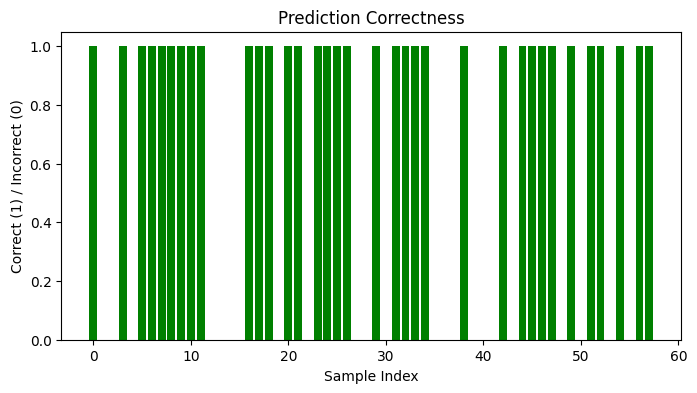

In [17]:
   # (4) 일치/불일치 정확도 그래프
correct = [1 if p == a else 0 for p, a in zip(predictions, actuals)]
plt.figure(figsize=(8, 4))
plt.bar(range(len(correct)), correct, color=['green' if x == 1 else 'red' for x in correct])
plt.title("Prediction Correctness")
plt.xlabel("Sample Index")
plt.ylabel("Correct (1) / Incorrect (0)")
plt.show()

In [18]:
wer_scores = [wer([a], [p]) for a, p in zip(actuals, predictions)]
cer_scores = [cer([a], [p]) for a, p in zip(actuals, predictions)]

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


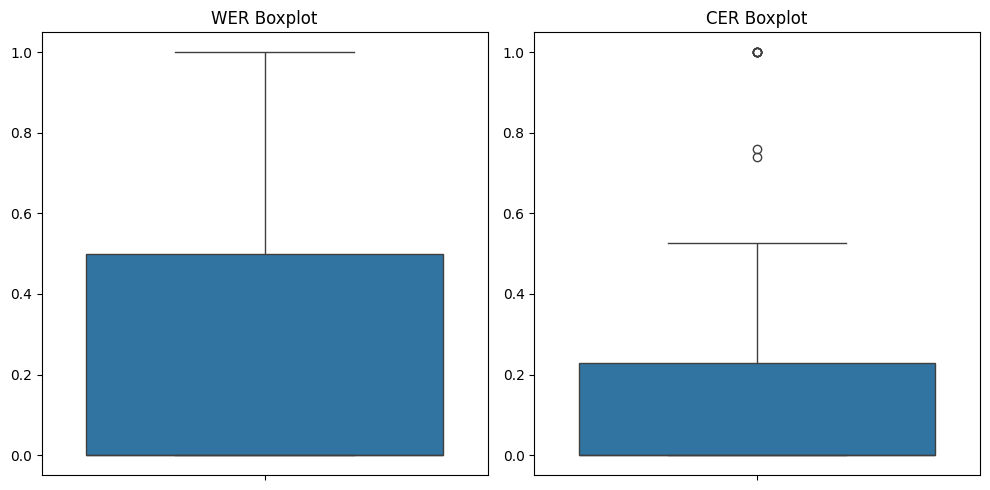

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
# (2) WER, CER Boxplot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.boxplot(wer_scores)
plt.title('WER Boxplot')

plt.subplot(1, 2, 2)
sns.boxplot(cer_scores)
plt.title('CER Boxplot')

plt.tight_layout()
plt.show()

In [ ]:
    plt.figure(figsize=(10, 5))

    # WER 시각화
    plt.subplot(1, 2, 1)
    plt.hist(wer_scores, bins=10, alpha=0.75, color='blue')
    plt.title('Word Error Rate (WER)')
    plt.xlabel('WER')
    plt.ylabel('Frequency')

    # CER 시각화
    plt.subplot(1, 2, 2)
    plt.hist(cer_scores, bins=10, alpha=0.75, color='green')
    plt.title('Character Error Rate (CER)')
    plt.xlabel('CER')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()